In [1]:
import numpy as np; np.random.seed(1234)
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mgcpy.independence_tests.mgc import MGC
from mgcpy.hypothesis_tests.transforms import k_sample_transform, paired_two_sample_test_dcorr

In [2]:
# paired two sample test
def transform_matrices(x, y):  # (n, p) shape
    '''
    Steps:
        - combine x and y to get the joint_distribution
        - sample n pairs from the joint_distribution
        - compute the eucledian distance between the sampled n pairs, which is ``randomly_sampled_pairs_distance``
        - compute the eucledian distance between the actual x and y, which is ``actual_pairs_distance``
        - compute the two sample transformed matrices of ``randomly_sampled_pairs_distance`` and ``actual_pairs_distance``
    '''
    joint_distribution = np.concatenate([x, y], axis=0)  # (2n, p) shape
    
    pairwise_sampled_xy = np.array([joint_distribution[np.random.randint(joint_distribution.shape[0], size=2), :] 
                                    for _ in range(x.shape[0])])  # (n, 2, p) shape
    pairwise_sampled_x = pairwise_sampled_xy[:, 0]  # (n, p) shape
    pairwise_sampled_y = pairwise_sampled_xy[:, 1]  # (n, p) shape

    # compute the eucledian distances
    randomly_sampled_pairs_distance = np.linalg.norm(pairwise_sampled_x - pairwise_sampled_y, axis=1)
    actual_pairs_distance = np.linalg.norm(x - y, axis=1)
    
    u, v = k_sample_transform(randomly_sampled_pairs_distance, actual_pairs_distance)
    
    return u, v

### Case 1:  
Assume a case where, X is sampled from _N(0,1)_ and Y = X + constant. This simulated **paired two sample data.**

/usr/local/var/pyenv/versions/py3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Samples'),
 Text(0.5,1,'Paired Two-Sample Data')]

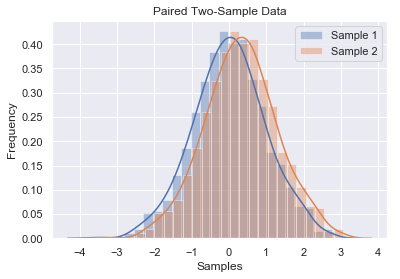

In [3]:
np.random.seed(1234)

# generate data
constant = 0.3

# case 1: paired data
paired_X = np.random.normal(0, 1, 1000).reshape(-1, 1)
paired_Y = paired_X + constant

# plot
fig, ax = plt.subplots()
sns.distplot(paired_X, ax=ax, label="Sample 1")
ax = sns.distplot(paired_Y, ax=ax, label="Sample 2")
ax.legend()
ax.set(xlabel='Samples', ylabel='Frequency', title='Paired Two-Sample Data')

In [4]:
# use MGC to perform independence test
u, v = transform_matrices(paired_X, paired_Y)
mgc = MGC()
p_value, p_value_metadata = mgc.p_value(u, v, is_fast=True)

In [5]:
print("p value:", p_value)
print("test statistic:", p_value_metadata["test_statistic"])

p value: 0.0
test statistic: 0.5093438250932688


### Case 2:  
Assume a case where, X is sampled from _N(0,1)_ and Y is sampled from _N(constant,1)_. This simulated **unpaired two sample data.** (where the _constant_ is the same as the one used above)

/usr/local/var/pyenv/versions/py3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Samples'),
 Text(0.5,1,'Unpaired Two-Sample Data')]

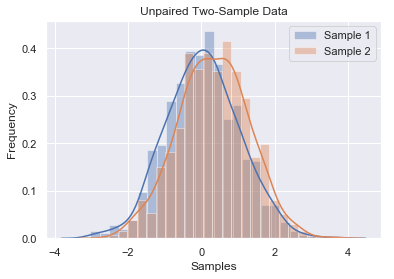

In [6]:
# generate data
# case 2: unpaired data
unpaired_X = np.random.normal(0, 1, 1000).reshape(-1, 1)
unpaired_Y = np.random.normal(constant, 1, 1000).reshape(-1, 1)

# plot
fig, ax = plt.subplots()
sns.distplot(unpaired_X, ax=ax, label="Sample 1")
ax = sns.distplot(unpaired_Y, ax=ax, label="Sample 2")
ax.legend()
ax.set(xlabel='Samples', ylabel='Frequency', title='Unpaired Two-Sample Data')

In [7]:
# use MGC to perform independence test
u, v = transform_matrices(unpaired_X, unpaired_Y)
mgc = MGC()
p_value, p_value_metadata = mgc.p_value(u, v, is_fast=True)

/usr/local/var/pyenv/versions/py3/envs/ML/lib/python3.6/site-packages/mgcpy-0.2.1-py3.6-macosx-10.13-x86_64.egg/mgcpy/independence_tests/mgc/mgc.py:293: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  "Use results such as test_statistic and optimal_scale, with caution!")


In [8]:
print("p value:", p_value)
print("test statistic:", p_value_metadata["test_statistic"])

p value: 0.6094352378976843
test statistic: -0.00022512609490192307


### Case 3:  
Take the same paired two sample data as in case 1, and apply it to the paired two-sample verison of dcorr.
This is got by replacing the distance transform of DCorr with: 
$teststatistic = varX/(n*(n-1)) + varY/(n*(n-1)) - 2*diag(covXY)/n$

In [9]:
# use DCorr to perform independence test on "paired" data
p_value, p_value_metadata = paired_two_sample_test_dcorr(paired_X, paired_Y)

/usr/local/var/pyenv/versions/py3/envs/ML/lib/python3.6/site-packages/mgcpy-0.2.1-py3.6-macosx-10.13-x86_64.egg/mgcpy/independence_tests/abstract_class.py:154: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  "Use results such as test_statistic and optimal_scale, with caution!")


In [10]:
print("p value:", p_value)
# print("test statistic:", p_value_metadata["test_statistic"])

p value: 1.0


### Case 4:  
Take the same unpaired two sample data as in case 2, and apply it to the paired two-sample verison of dcorr.
This is got by replacing the distance transform of DCorr with: 
$teststatistic = varX/(n*(n-1)) + varY/(n*(n-1)) - 2*diag(covXY)/n$

In [11]:
# use DCorr to perform independence test on "unpaired" data
p_value, p_value_metadata = paired_two_sample_test_dcorr(unpaired_X, unpaired_Y)

/usr/local/var/pyenv/versions/py3/envs/ML/lib/python3.6/site-packages/mgcpy-0.2.1-py3.6-macosx-10.13-x86_64.egg/mgcpy/independence_tests/abstract_class.py:154: UserWarning: The p-value is greater than 0.05, implying that the results are not statistically significant.
Use results such as test_statistic and optimal_scale, with caution!
  "Use results such as test_statistic and optimal_scale, with caution!")


In [12]:
print("p value:", p_value)
# print("test statistic:", p_value_metadata["test_statistic"])

p value: 0.806
